In [6]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import skimage.io
import skimage
import cv2
import tifffile as tiff 
import numpy as np
import tifffile as tiff
import xmltodict as xd, numpy as np, pickle
from collections import defaultdict
import pandas as pd
import matplotlib, matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=300
import seaborn as sns
#tiff.imread
# arr=cv2.imread("old_data/final_skin/51_D1b_ASAP.tif")
slide1=False

arr=(np.array(Image.open("data/51_D1b_ASAP.tif")) if not slide1 else np.load("data/41_A2c.npy"))
with open("data/{}.xml".format("41_A2c_ASAP" if slide1 else "51_D1b_ASAP"),"rb") as f:
    d=xd.parse(f)
    
cells=[]
cell_dot=[]
for i,annotation in enumerate(d['ASAP_Annotations']["Annotations"]["Annotation"]):
#     print(annotation["@PartOfGroup"])
#     print(annotation)
#     break
#     if annotation["@PartOfGroup"]=="nuc":
    if annotation["@Type"]=="Dot":
        cell_dot.append(np.array((float(annotation["Coordinates"]["Coordinate"]["@X"]),float(annotation["Coordinates"]["Coordinate"]["@Y"]))))
    elif annotation["@Type"]=="Spline":
        try:
            lbl=annotation["@PartOfGroup"]
            contour=np.array([(float(coord["@X"]),float(coord["@Y"])) for coord in annotation["Coordinates"]["Coordinate"]])
            cells.append(contour)
        except:
            print(i)
            
contour_df=pd.DataFrame(cells,columns=['contours'])
contour_df['xmin']=contour_df['contours'].map(lambda x: x[:,0].min())
contour_df['xmax']=contour_df['contours'].map(lambda x: x[:,0].max())
contour_df['ymin']=contour_df['contours'].map(lambda x: x[:,1].min())
contour_df['ymax']=contour_df['contours'].map(lambda x: x[:,1].max())
contour_df['xmean']=contour_df['contours'].map(lambda x: x[:,0].mean())
contour_df['ymean']=contour_df['contours'].map(lambda x: x[:,1].mean())



In [7]:
dot_annotations=pd.DataFrame(cell_dot,columns=['x','y'])
from sklearn.metrics import silhouette_samples
import seaborn as sns
from sklearn.cluster import SpectralClustering, AgglomerativeClustering,Birch,KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from hdbscan import HDBSCAN
sc=KMeans(random_state=42,n_clusters=10) if slide1 else BayesianGaussianMixture(n_components=5,random_state=42,covariance_type="full",init_params="random",weight_concentration_prior_type="dirichlet_distribution")#SpectralClustering(n_clusters=7,affinity='nearest_neighbors',assign_labels="discretize",n_neighbors=7)
c=sc.fit_predict(dot_annotations)#10

c2=sc.predict(contour_df[['xmean','ymean']])
include_contour=(silhouette_samples(contour_df[['xmean','ymean']], c2)>=(0.3 if slide1 else 0.05))
contour_df=contour_df[include_contour]#.mean()#0.5
c2=c2[include_contour]

dot_annotations['cluster']=c
contour_df['cluster']=c2

contour_df['perimeter']=contour_df['contours'].map(lambda x: np.sqrt((np.diff(x,axis=0)**2).sum(axis=1)).sum())

idx_keep=contour_df['perimeter'].values.argsort()[::-1][(4 if slide1 else 8):]
contour_df=contour_df.iloc[idx_keep]
c2=c2[idx_keep]



In [8]:
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# define pts from the question
def fit_spline(pts):
    try:
        okay = np.where(np.abs(np.diff(pts,axis=0)).sum(1) > 0)[0]
        pts = np.vstack([pts[okay], pts[-1]])#, pts[0]
#     print(pts)
#     print(pts)
#     yp = np.r_[yp[okay], yp[-1], yp[0]]

        tck, u = splprep(pts.T, u=None, s=0.0, per=1) 
        u_new = np.linspace(u.min(), u.max(), 1000)
        x_new, y_new = splev(u_new, tck, der=0)
        pts=np.vstack((x_new, y_new)).T
    except:
        pass

#     plt.plot(pts[:,0], pts[:,1], 'ro')
#     plt.plot(x_new, y_new, 'b--')
    return pts

from skimage import draw
import numpy as np
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

contours_df2=contour_df.copy()
contours_df2.loc[:,'contours']=contours_df2['contours'].map(fit_spline)
contours_df2['xmin']=contours_df2['contours'].map(lambda x: x[:,0].min())
contours_df2['xmax']=contours_df2['contours'].map(lambda x: x[:,0].max())
contours_df2['ymin']=contours_df2['contours'].map(lambda x: x[:,1].min())
contours_df2['ymax']=contours_df2['contours'].map(lambda x: x[:,1].max())



/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][12]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][12]=x[1][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][16]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][16]=x[1][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][11]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][11]=x[1][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][14]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3

In [9]:
nuclei_annotations=cv2.fillPoly(np.zeros(arr.shape[:2]), pts=contours_df2['contours'].map(lambda x:x.astype(int)).tolist(), color=1)

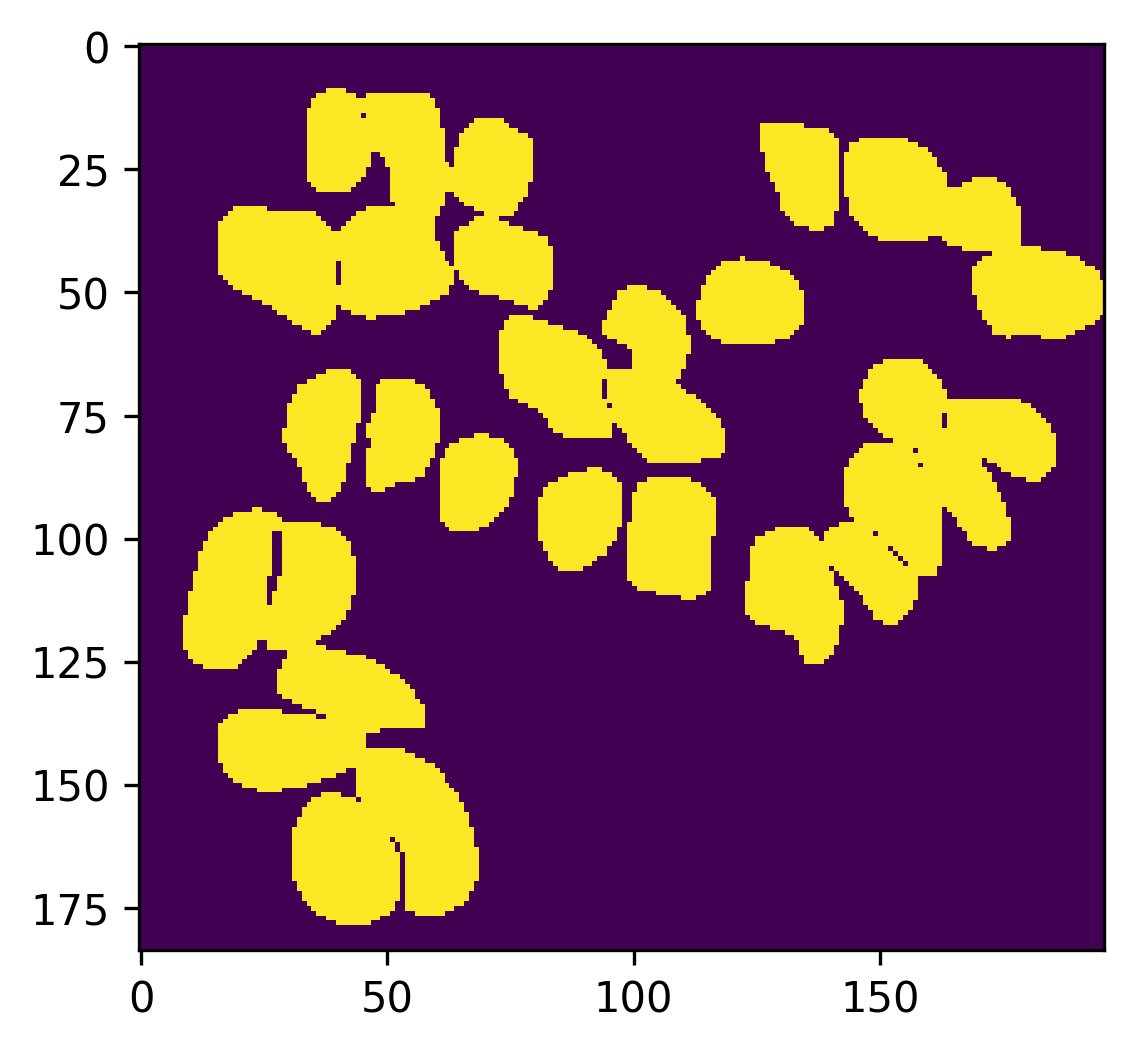

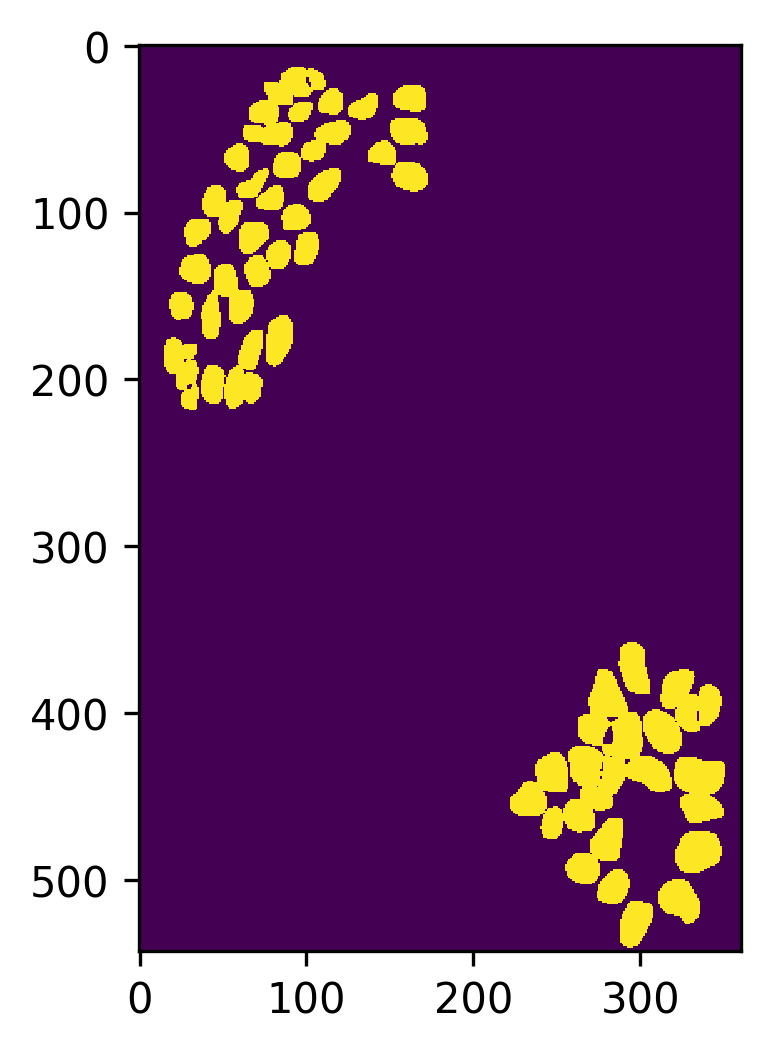

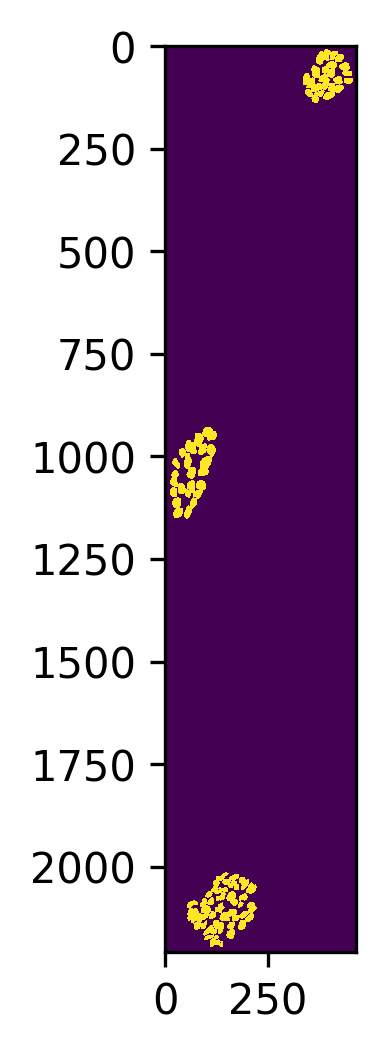

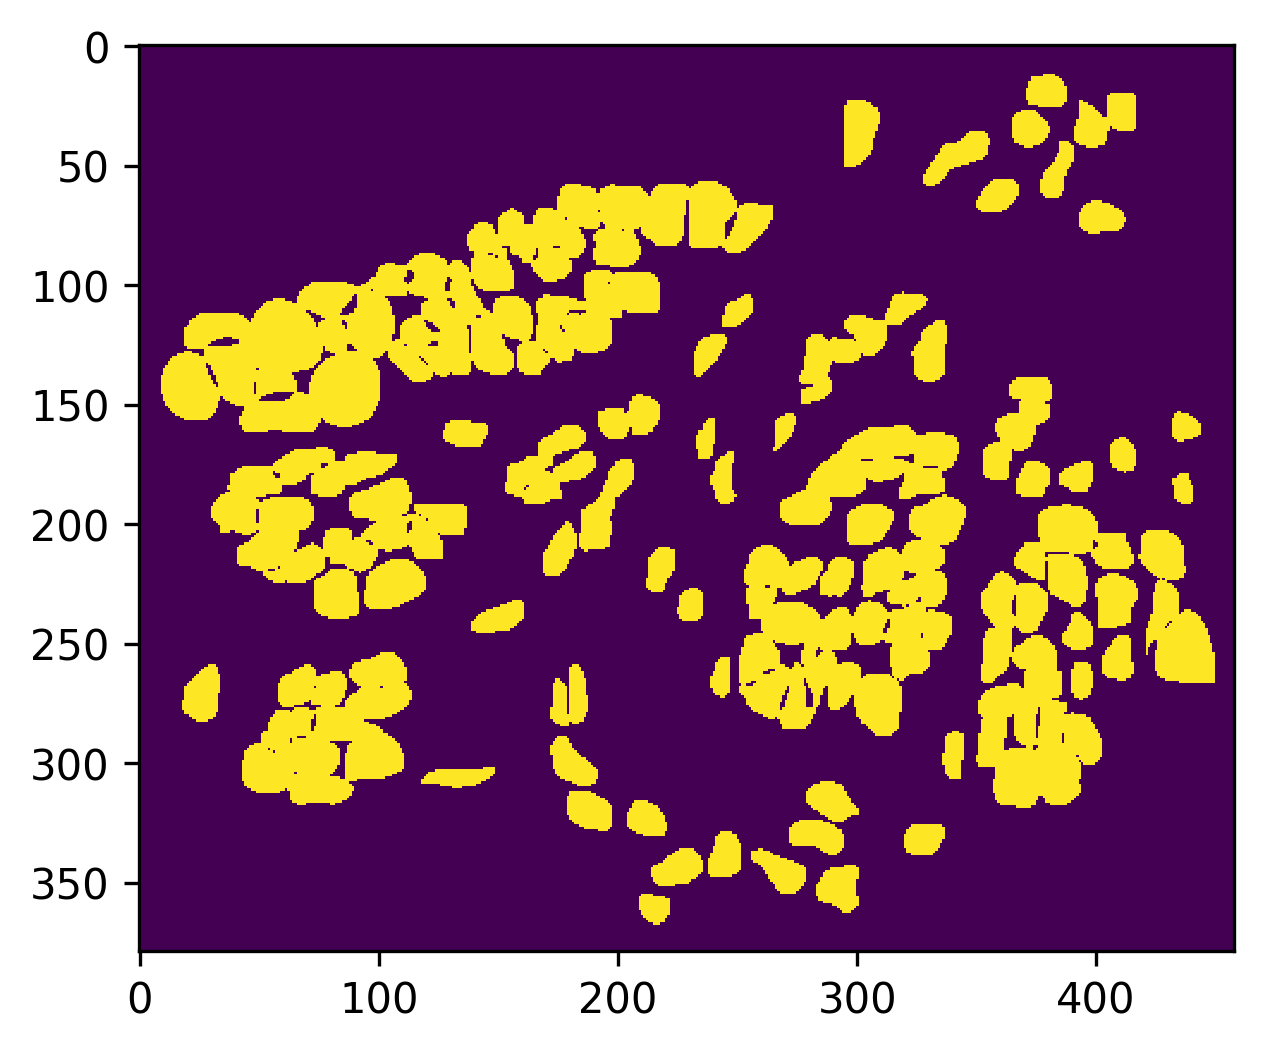

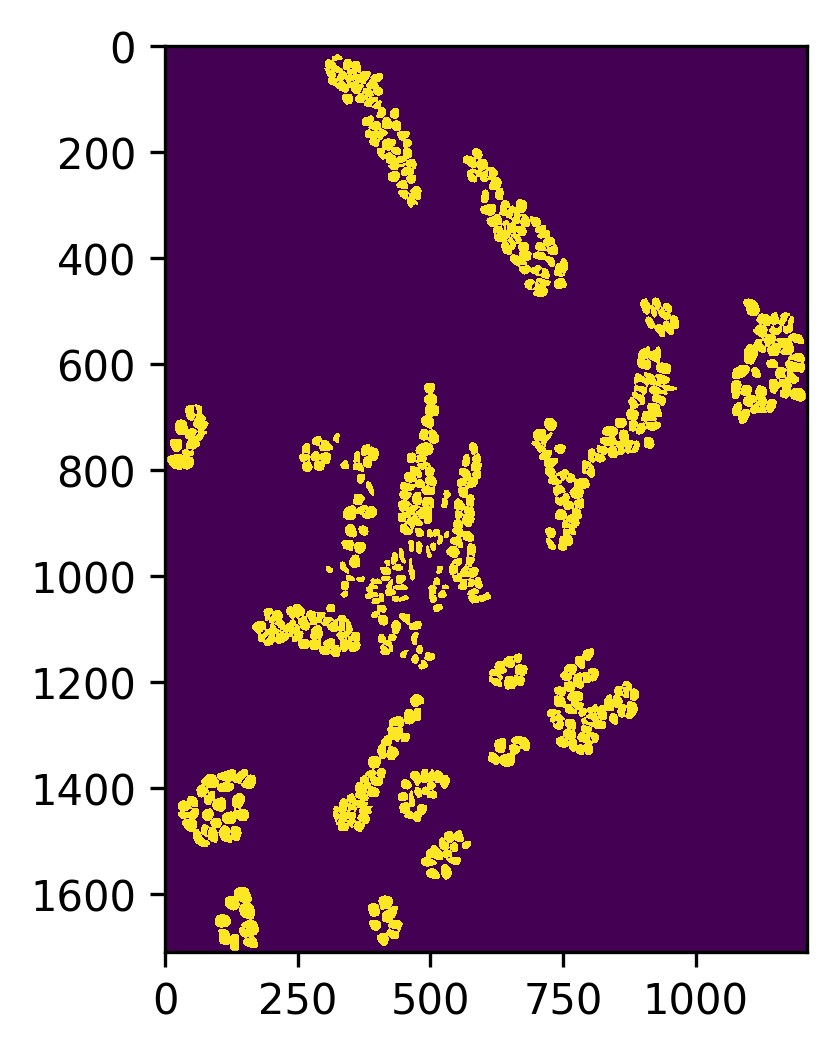

In [10]:
import copy
matplotlib.rcParams['figure.dpi']=300
cell_imgs=[]
images=[]
cluster_box=dict()
image_set=[]
for i,(name,dff) in enumerate(dot_annotations.groupby("cluster")):
#     if i==2:
    xmin,xmax,ymin,ymax=dff['x'].min(),dff['x'].max(),dff['y'].min(),dff['y'].max()
    xmin,xmax,ymin,ymax=int(xmin)-20,int(xmax)+20,int(ymin)-20,int(ymax)+20
    cluster_box[name]=[xmin,xmax,ymin,ymax]
    dff.loc[:,'x']=dff['x']-xmin
    dff.loc[:,'y']=dff['y']-ymin
    images.append(dict(dot_annot=dff,
                       region_box=cluster_box[name]))
    plt.figure()
    plt.imshow(nuclei_annotations[ymin:ymax,xmin:xmax])#arr[ymin:ymax,xmin:xmax,:])
    image_set.append((arr[ymin:ymax,xmin:xmax,:],nuclei_annotations[ymin:ymax,xmin:xmax]))
#     plt.scatter(dff['x'],dff['y'],s=1)
    
# cv2.fillPoly(np.zeros(img.shape[:2]), pts=contour_df['contours_spline'].map(lambda x:x.astype(int)).tolist(), color=1)

# for i in range(contours_df2.shape[0]):
# #     if i==500:
#     xmin,xmax,ymin,ymax=contours_df2.iloc[i][['xmin','xmax','ymin','ymax']]
#     xmin=int(xmin)
#     ymin=int(ymin)
#     xmax=int(round(xmax))
#     ymax=int(round(ymax))
#     contour=contours_df2.iloc[i]['contours']-np.array([xmin,ymin])
#     img=copy.deepcopy(arr[ymin:ymax,xmin:xmax,:])
#     mask=poly2mask(contour[:,1],contour[:,0],img.shape[:2])
#     img[~mask]=255
#     cell_imgs.append(img)

In [22]:
image_set[0][0].shape

(549, 602, 3)

In [18]:
from sklearn.feature_extraction.image import PatchExtractor
patch_size=100
ds=50
patches=[]
for img,image in enumerate(image_set):
    
    for x in np.arange(0,image[0].shape[0]-ds,ds).astype(int):
        for y in np.arange(0,image[0].shape[1]-ds,ds).astype(int):
            patches.append((img,image[0][x:x+patch_size,y:y+patch_size].astype(float)/255.,image[1][x:x+patch_size,y:y+patch_size].astype(int)))
        
patches=pd.DataFrame(patches)
patches=patches.loc[(patches[2].map(np.mean)>(0.01 if slide1 else 0.1))]


In [3]:
! free -g

              total        used        free      shared  buff/cache   available
Mem:            565         104         384           3          76         455
Swap:           127           0         127


In [20]:
patches.to_pickle("data/41_A2c.patches.pkl" if slide1 else "data/51_D1b.patches.pkl")

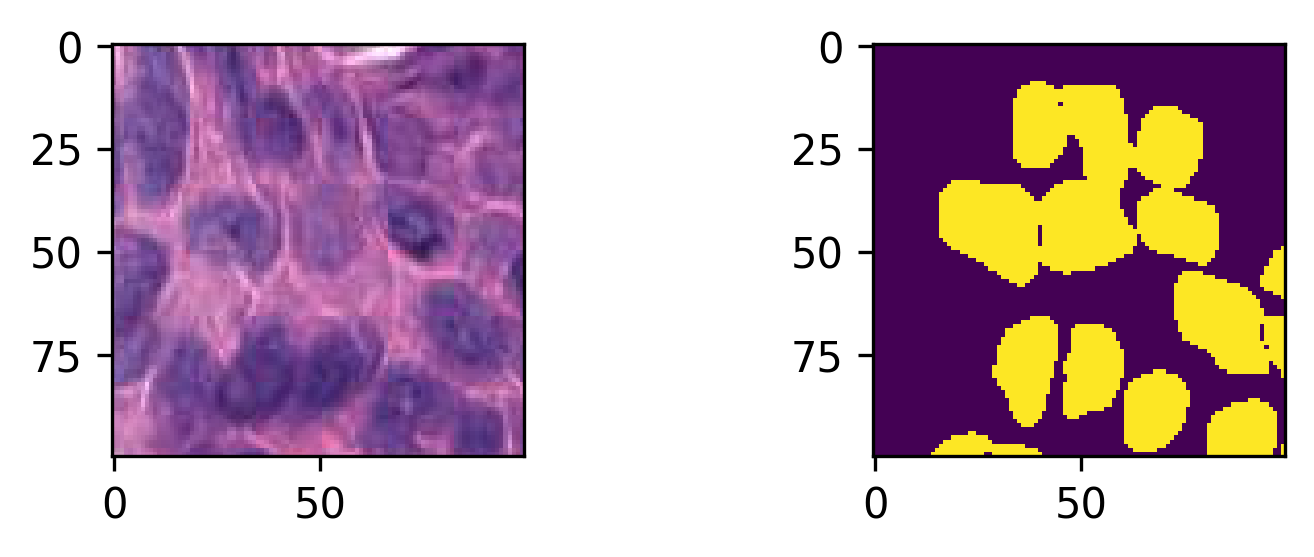

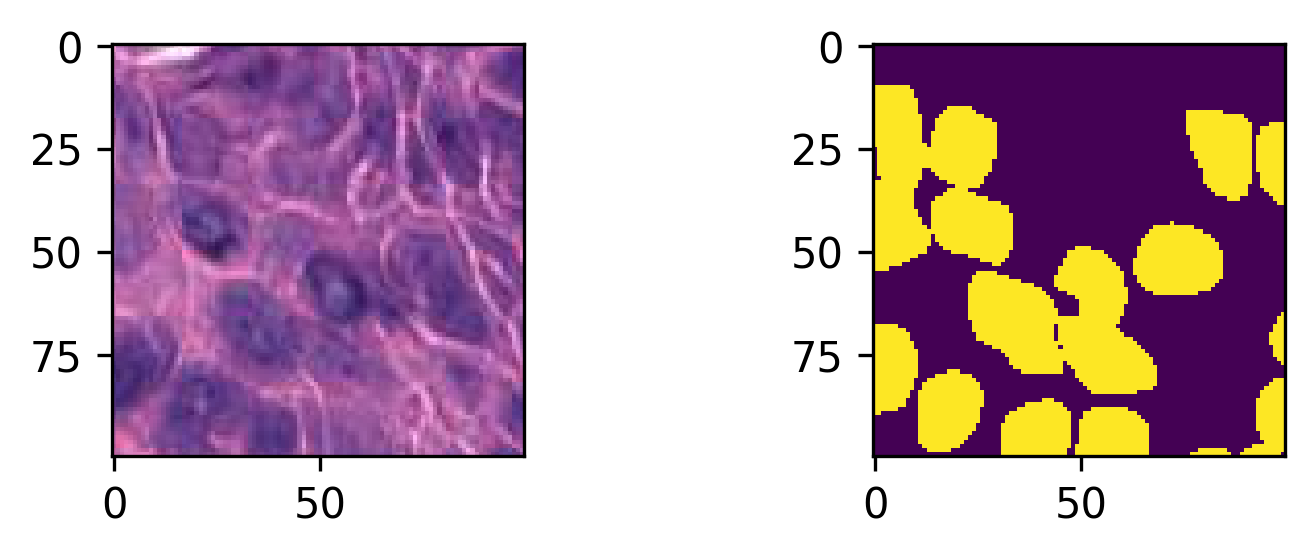

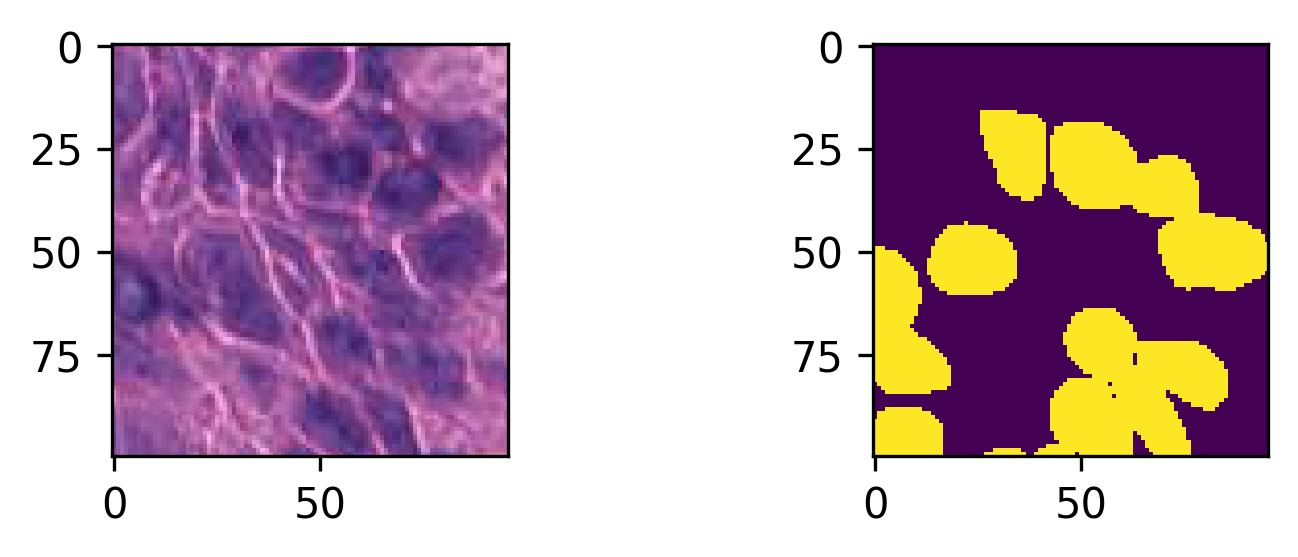

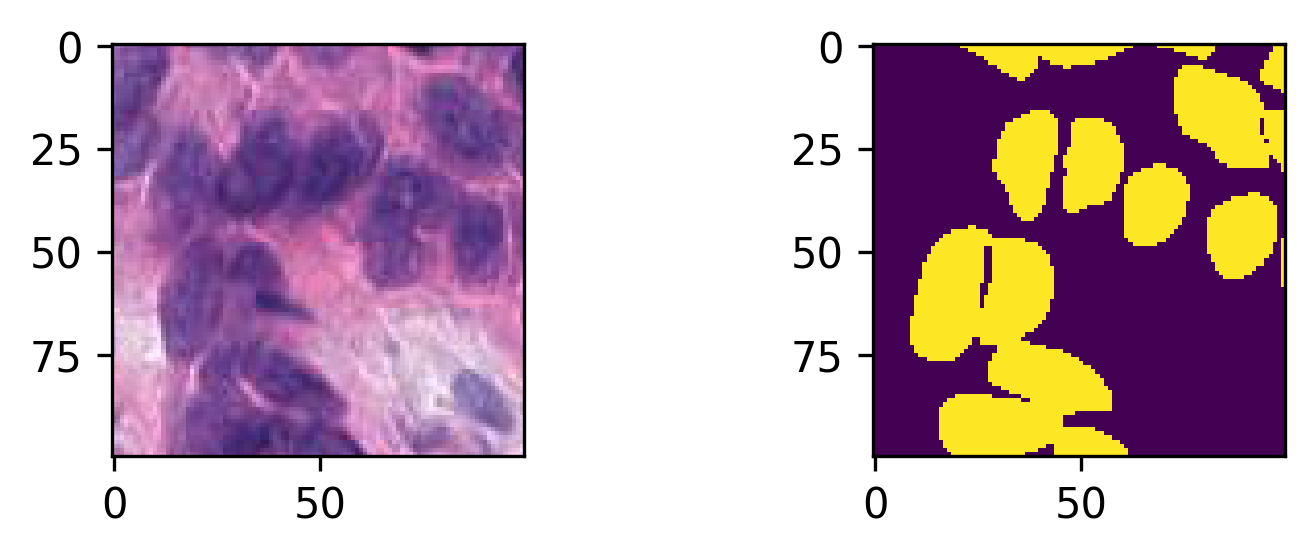

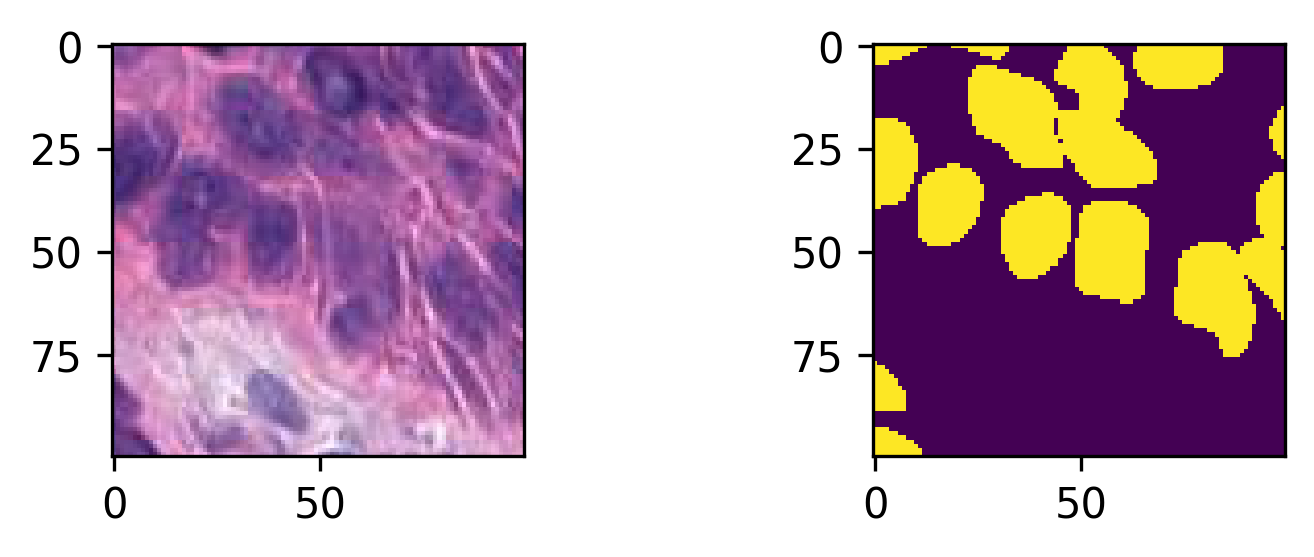

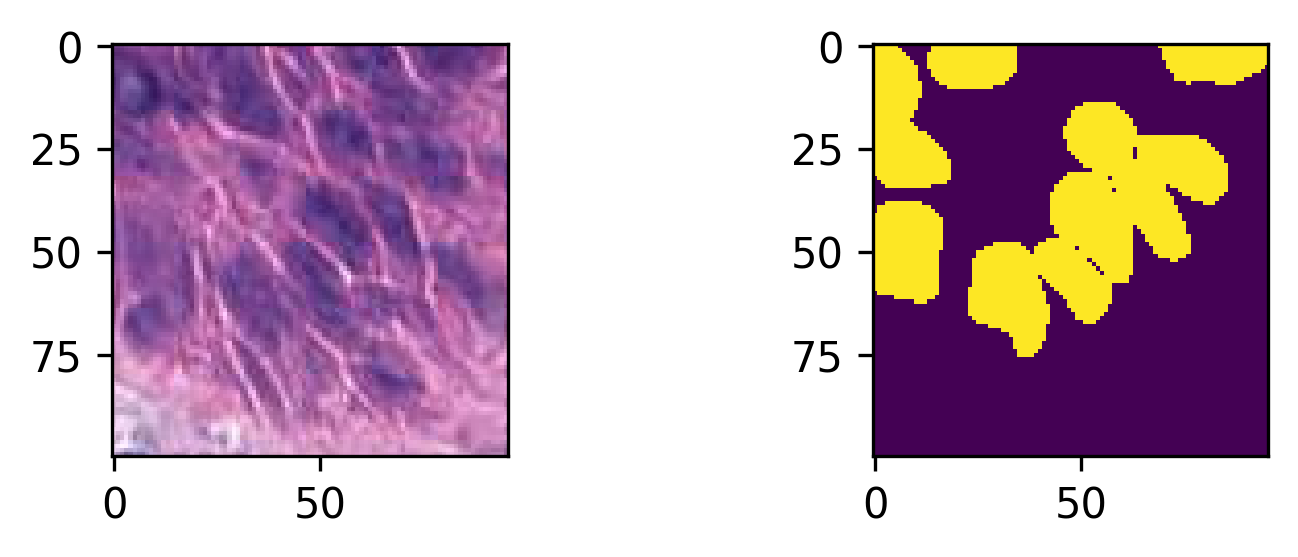

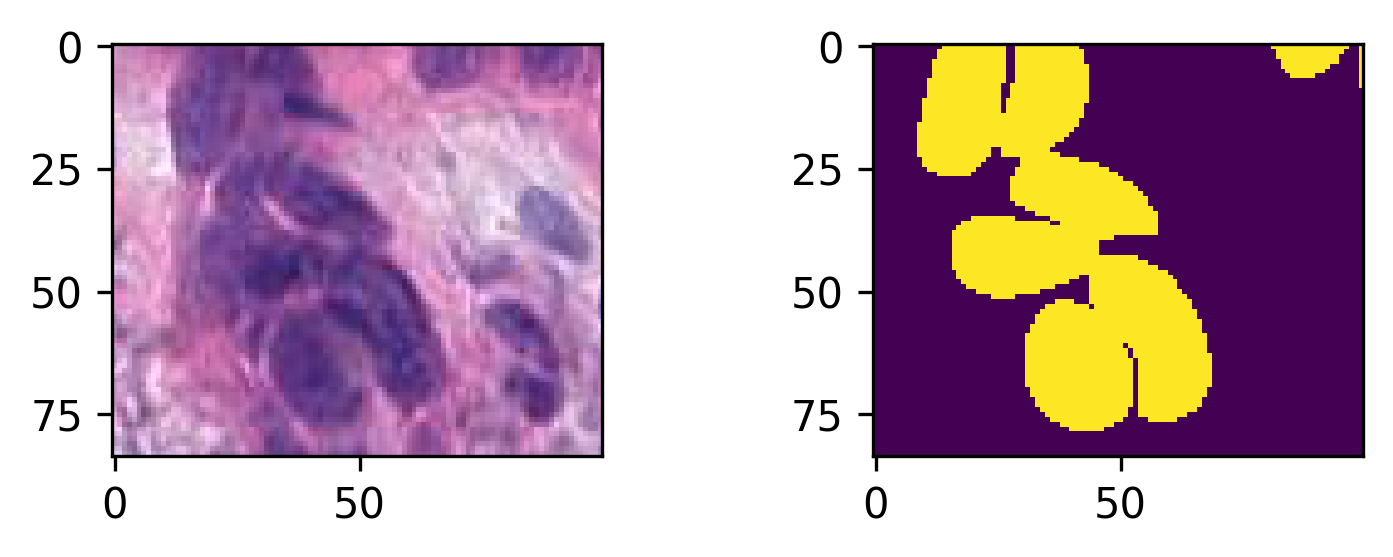

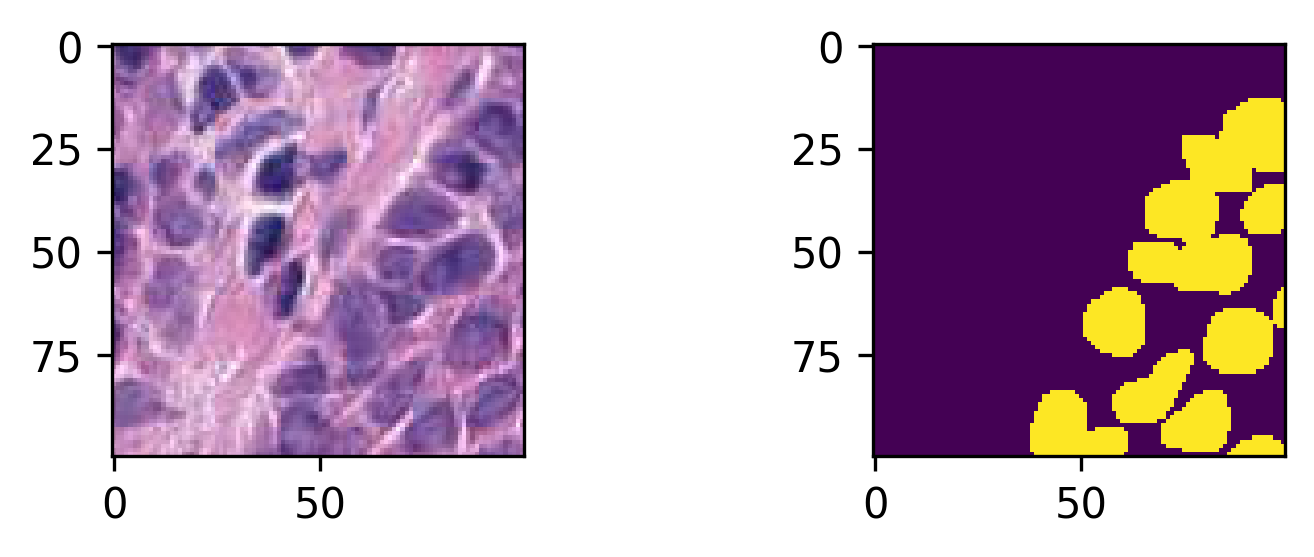

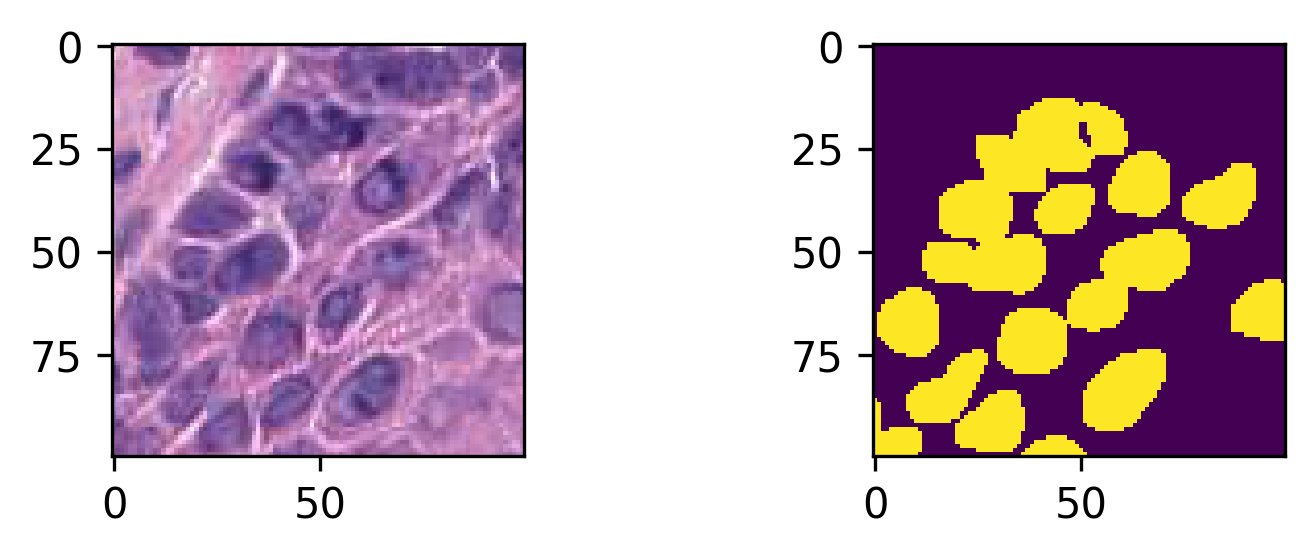

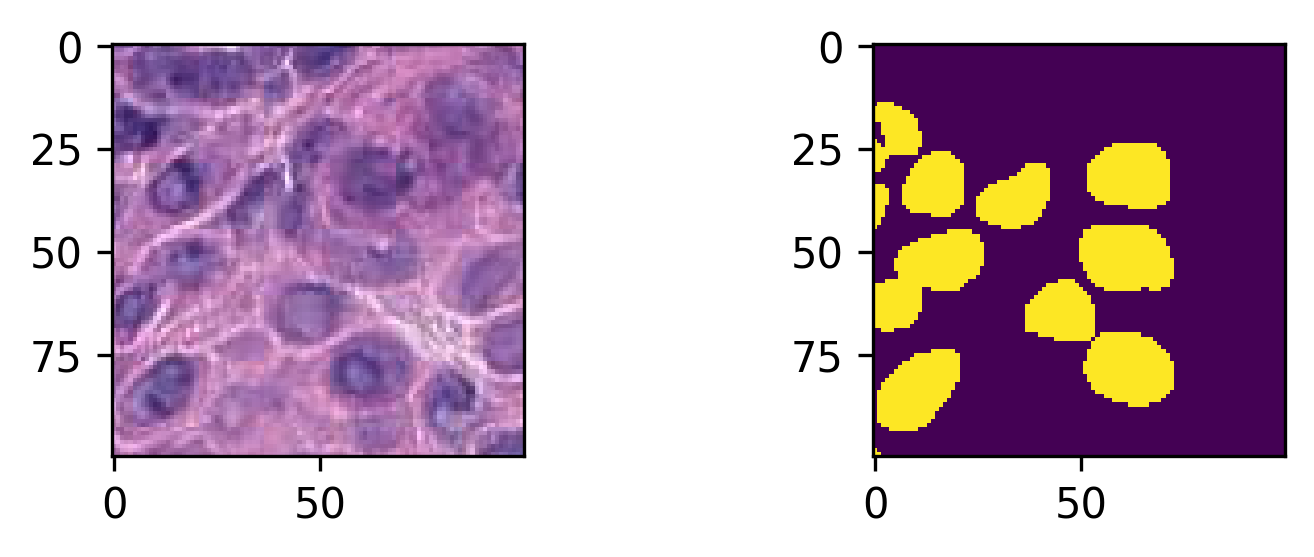

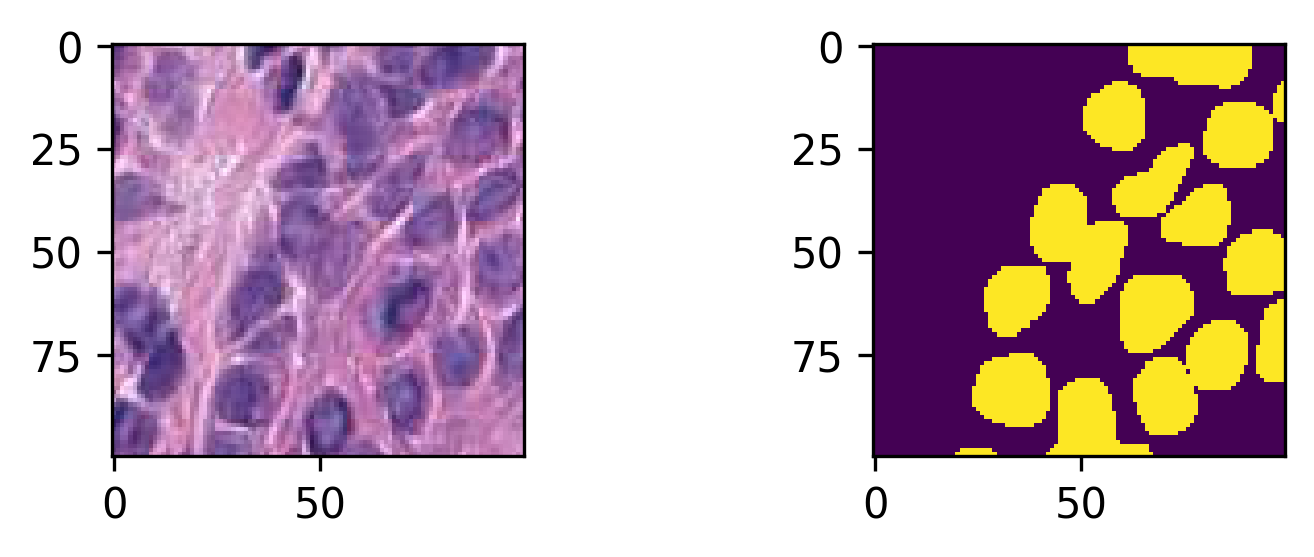

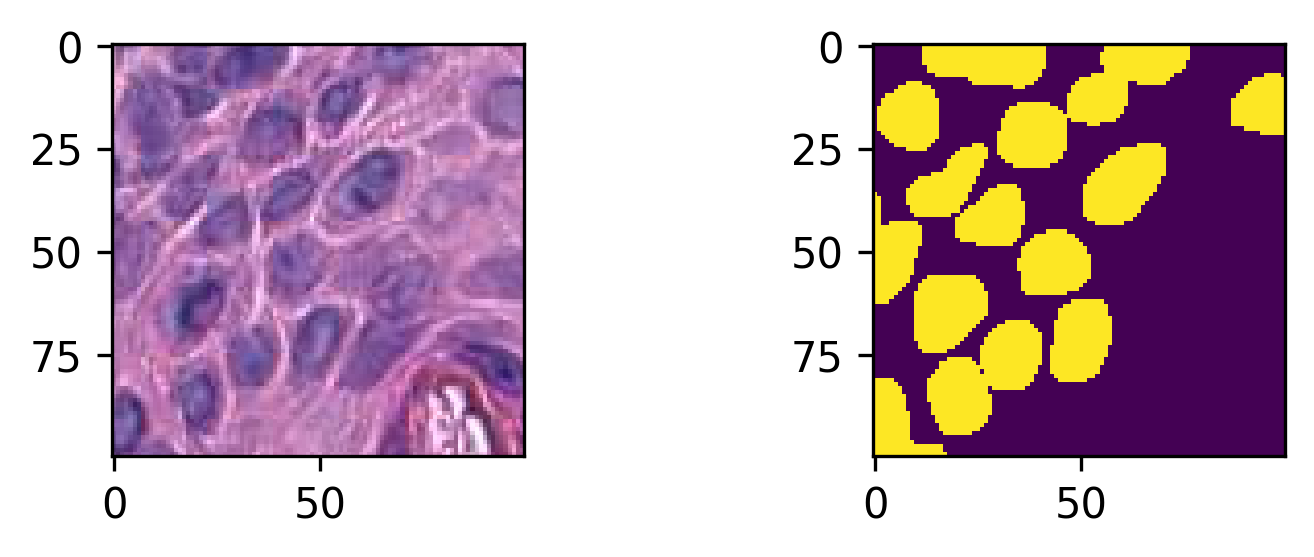

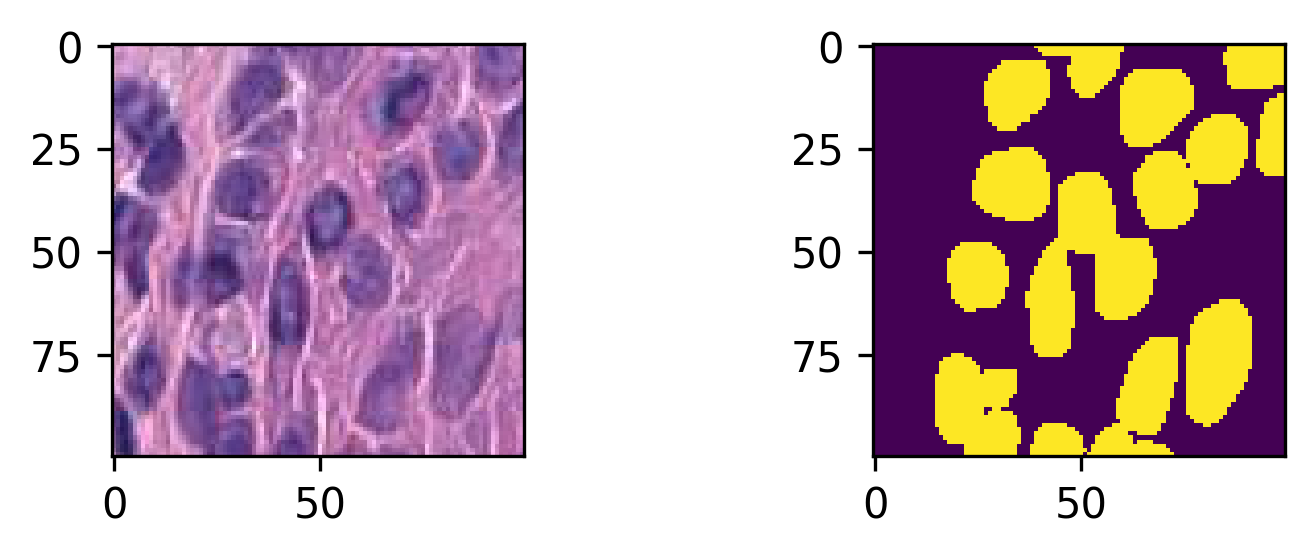

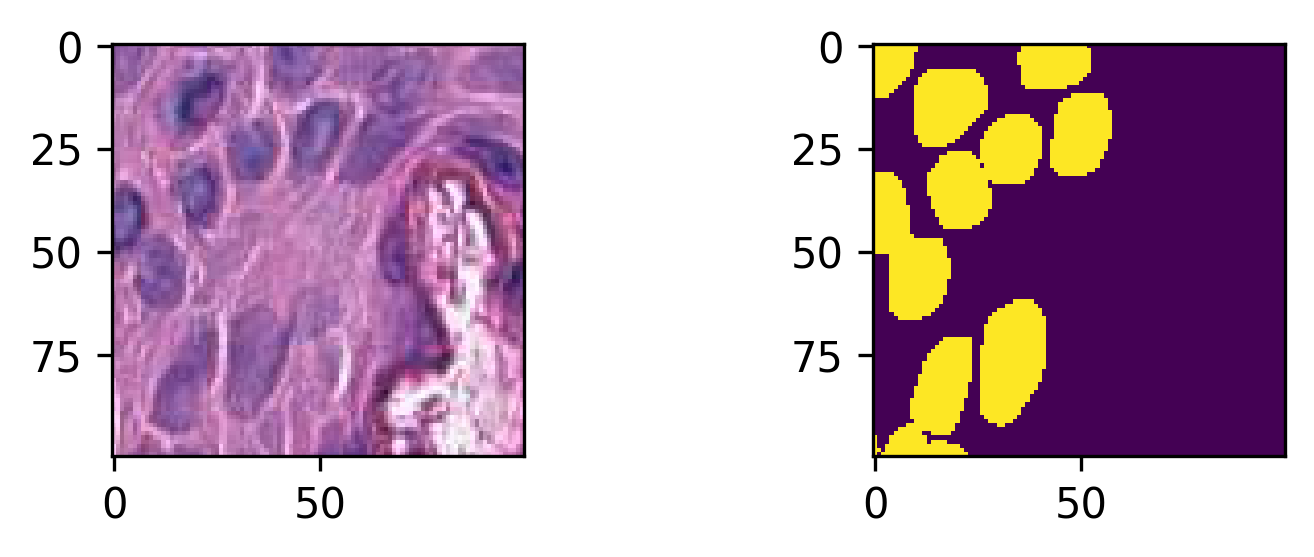

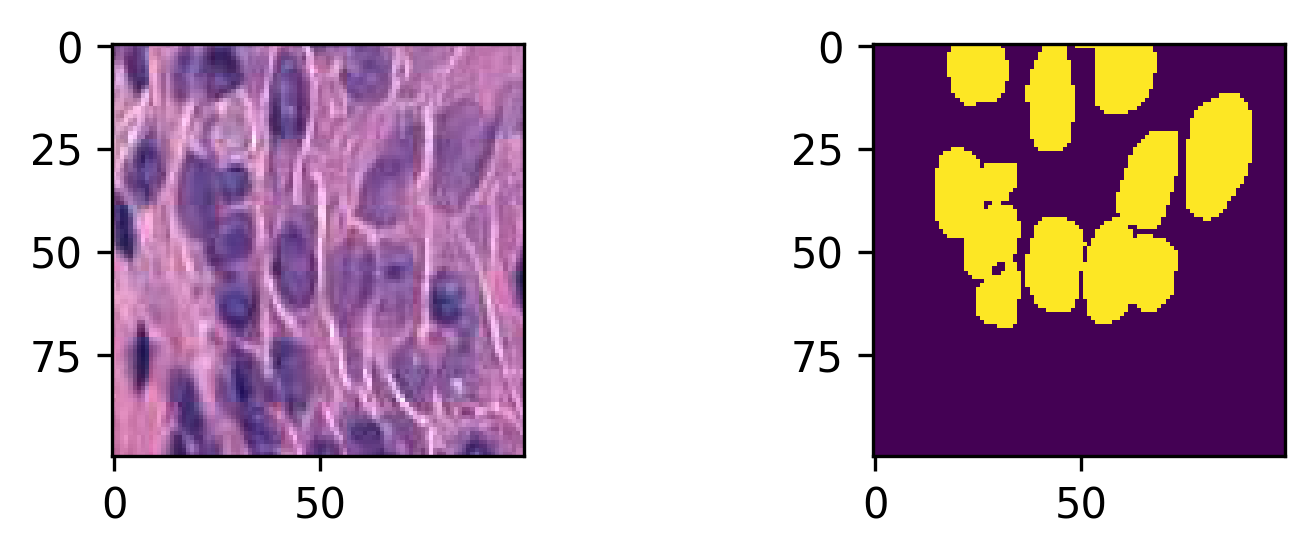

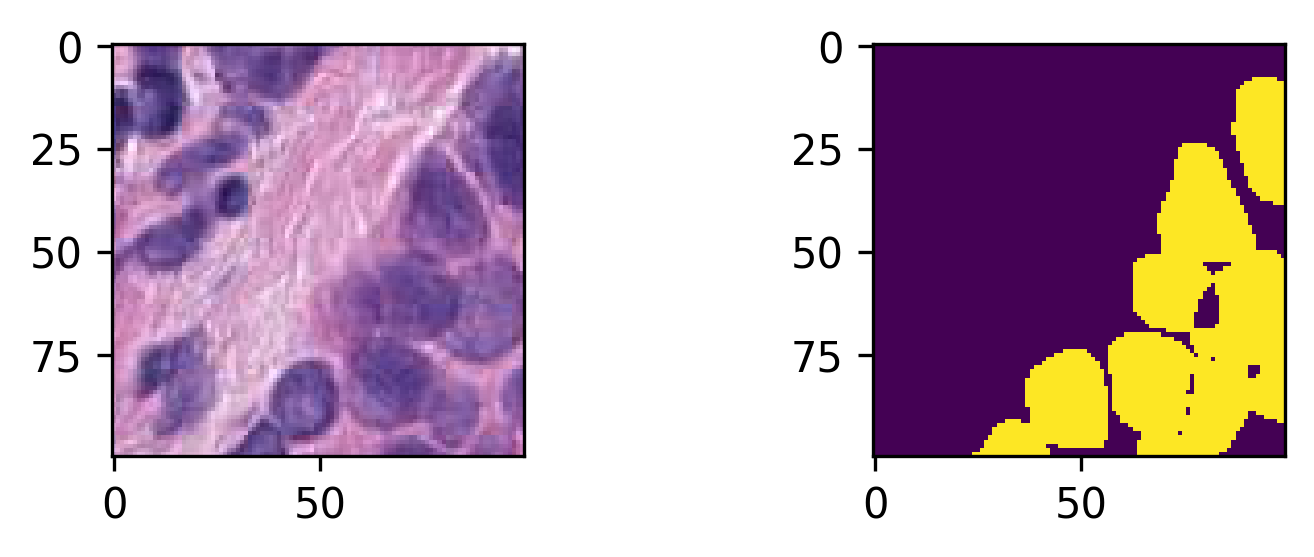

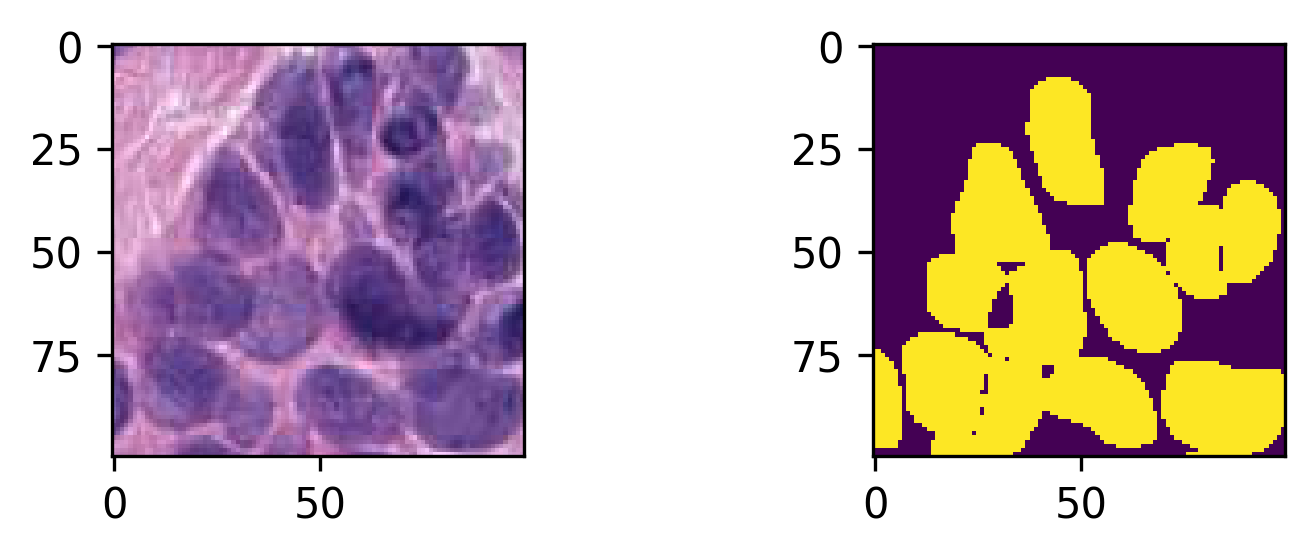

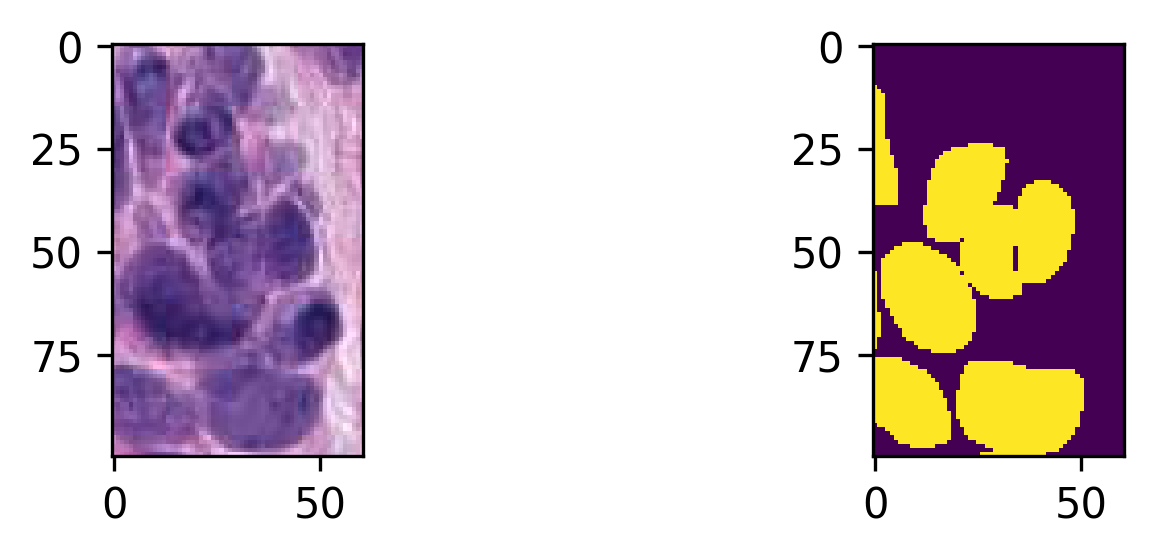

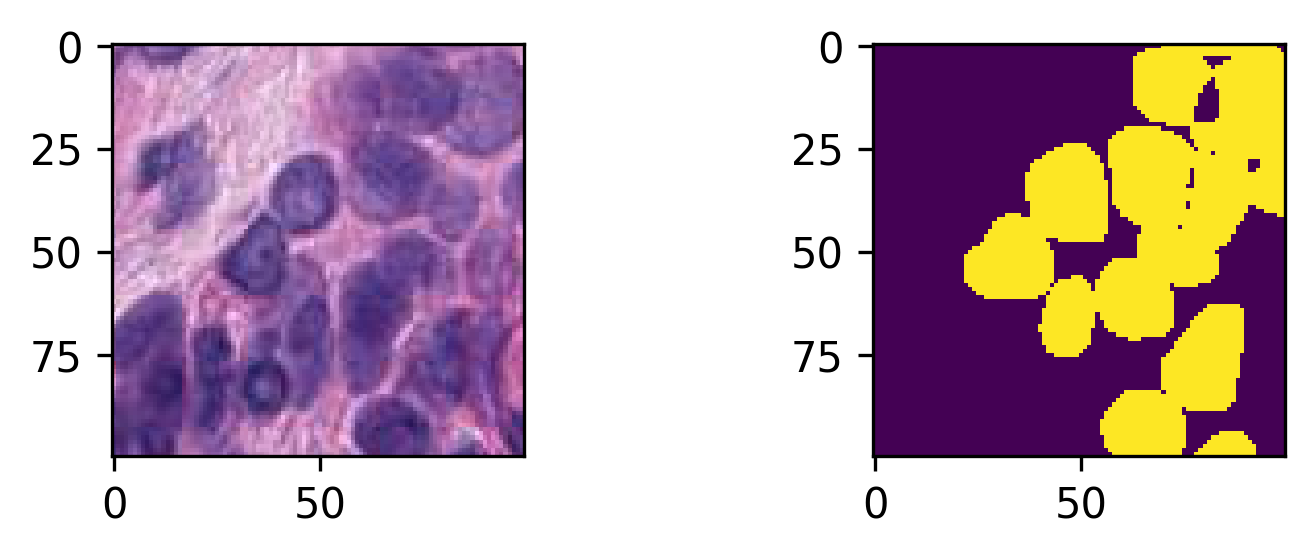

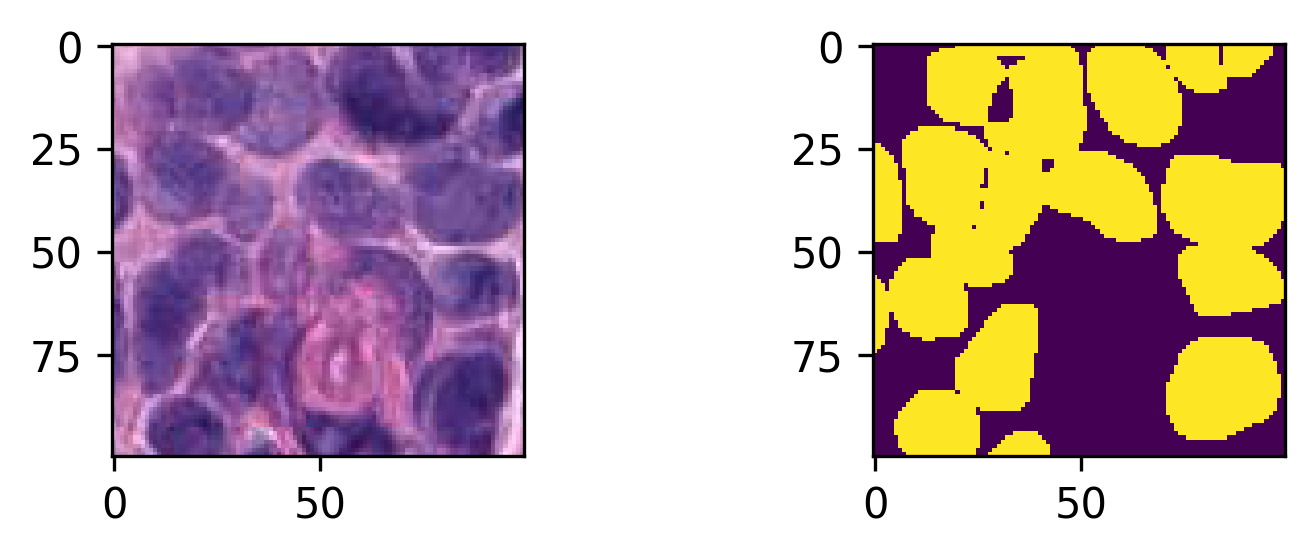

In [17]:
for i in range(20):
    plt.figure()
    plt.subplot(221)
    plt.imshow(patches.iloc[i,1])
    plt.subplot(222)
    plt.imshow(patches.iloc[i,2])


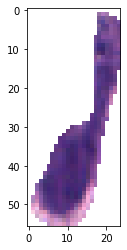

In [7]:
import matplotlib, matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(cell_imgs[0])

In [ ]:
###

In [29]:
arr=(np.load("data/131_B1e.npy"))
with open("data/{}.xml".format("131_B1e_ASAP_nuc.xml"),"rb") as f:
    d=xd.parse(f)
    
cells=[]
cell_dot=[]
for i,annotation in enumerate(d['ASAP_Annotations']["Annotations"]["Annotation"]):
#     print(annotation["@PartOfGroup"])
#     print(annotation)
#     break
#     if annotation["@PartOfGroup"]=="nuc":
#     if annotation["@Type"]=="Dot":
#         cell_dot.append(np.array((float(annotation["Coordinates"]["Coordinate"]["@X"]),float(annotation["Coordinates"]["Coordinate"]["@Y"]))))
#     elif annotation["@Type"] in ["Spline",""]:
    try:
        lbl=annotation["@PartOfGroup"]
        contour=np.array([(float(coord["@X"]),float(coord["@Y"])) for coord in annotation["Coordinates"]["Coordinate"]])
        cells.append(contour)
    except:
        print(i)
            
contour_df=pd.DataFrame(cells,columns=['contours'])
contour_df['xmin']=contour_df['contours'].map(lambda x: x[:,0].min())
contour_df['xmax']=contour_df['contours'].map(lambda x: x[:,0].max())
contour_df['ymin']=contour_df['contours'].map(lambda x: x[:,1].min())
contour_df['ymax']=contour_df['contours'].map(lambda x: x[:,1].max())
contour_df['xmean']=contour_df['contours'].map(lambda x: x[:,0].mean())
contour_df['ymean']=contour_df['contours'].map(lambda x: x[:,1].mean())

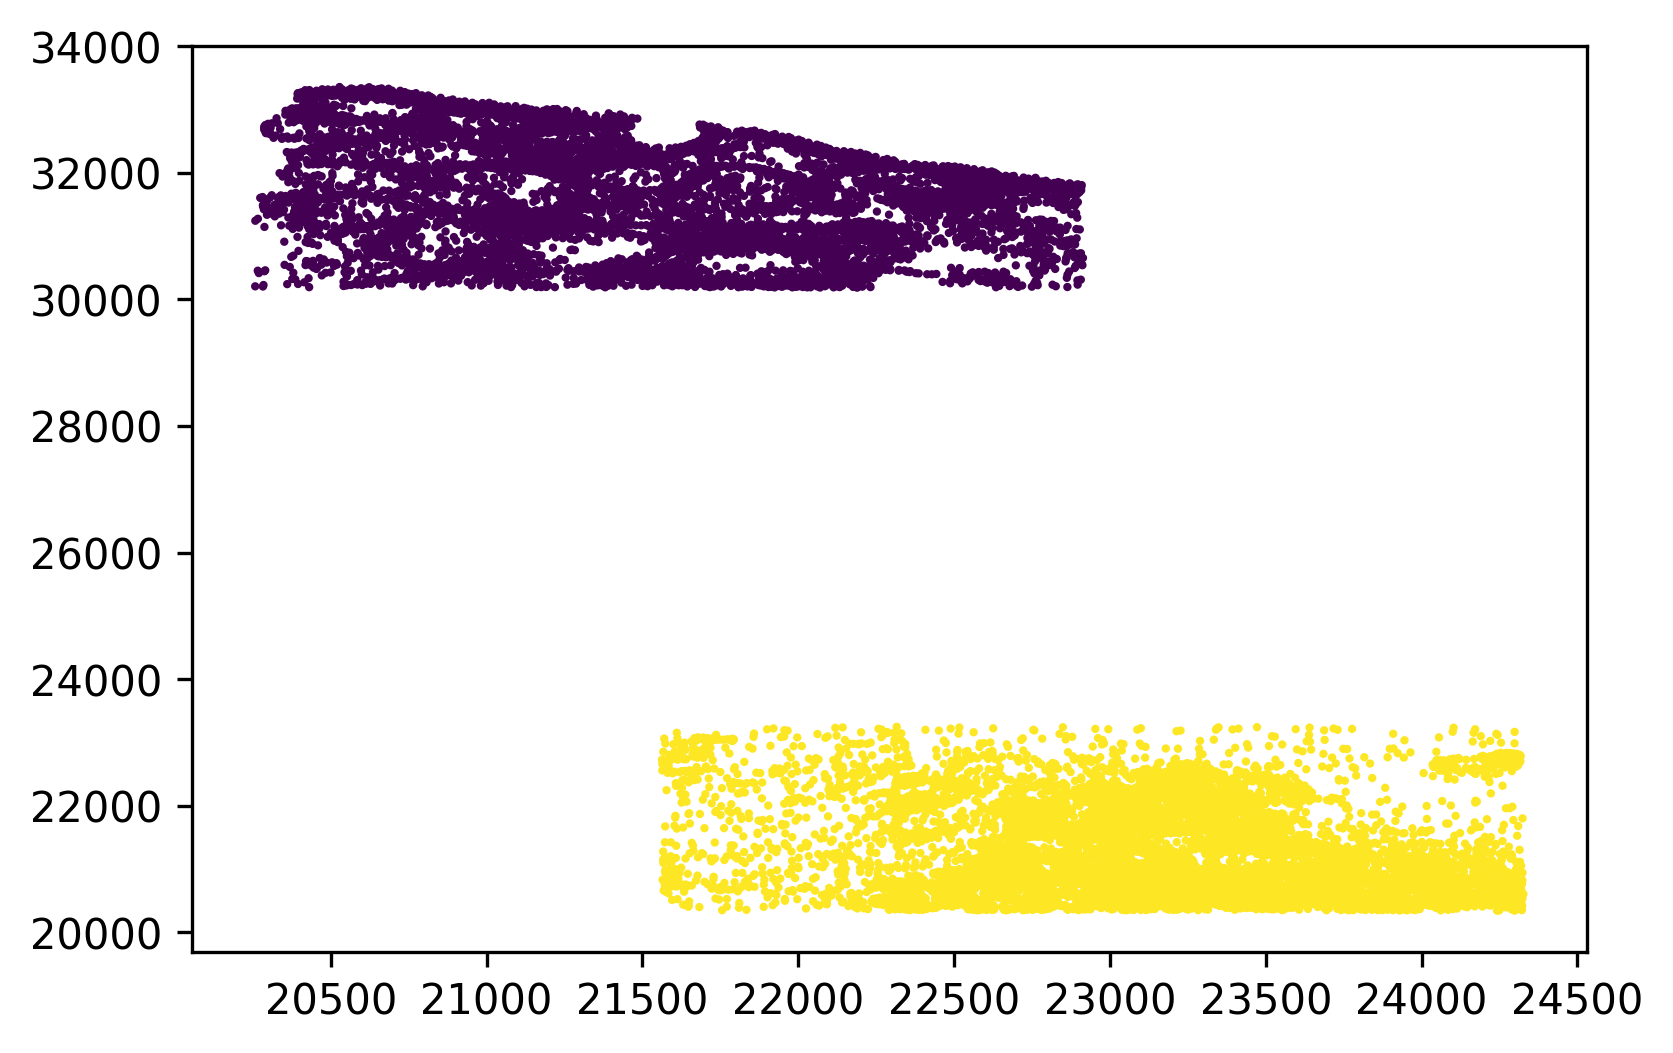

In [39]:
# dot_annotations=pd.DataFrame(cell_dot,columns=['x','y'])
from sklearn.metrics import silhouette_samples
import seaborn as sns
from sklearn.cluster import SpectralClustering, AgglomerativeClustering,Birch,KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from hdbscan import HDBSCAN
# plt.scatter(contour_df['xmean'])
c=KMeans(random_state=42,n_clusters=2).fit_predict(contour_df[['xmean','ymean']])

plt.scatter(*contour_df[['xmean','ymean']].T.values.tolist(),s=1,c=c.flatten())

In [32]:
# contour_df

In [40]:
contour_df['cluster']=c

In [41]:
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# define pts from the question
def fit_spline(pts):
    try:
        okay = np.where(np.abs(np.diff(pts,axis=0)).sum(1) > 0)[0]
        pts = np.vstack([pts[okay], pts[-1]])#, pts[0]
#     print(pts)
#     print(pts)
#     yp = np.r_[yp[okay], yp[-1], yp[0]]

        tck, u = splprep(pts.T, u=None, s=0.0, per=1) 
        u_new = np.linspace(u.min(), u.max(), 1000)
        x_new, y_new = splev(u_new, tck, der=0)
        pts=np.vstack((x_new, y_new)).T
    except:
        pass

#     plt.plot(pts[:,0], pts[:,1], 'ro')
#     plt.plot(x_new, y_new, 'b--')
    return pts

from skimage import draw
import numpy as np
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

contours_df2=contour_df.copy()
contours_df2.loc[:,'contours']=contours_df2['contours'].map(fit_spline)
contours_df2['xmin']=contours_df2['contours'].map(lambda x: x[:,0].min())
contours_df2['xmax']=contours_df2['contours'].map(lambda x: x[:,0].max())
contours_df2['ymin']=contours_df2['contours'].map(lambda x: x[:,1].min())
contours_df2['ymax']=contours_df2['contours'].map(lambda x: x[:,1].max())


/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][5]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][5]=x[1][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][7]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][7]=x[1][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][8]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][8]=x[1][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][6]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site

In [51]:
contours_df2=contours_df2.loc[(contours_df2['xmax']-contours_df2['xmin'])<1000]

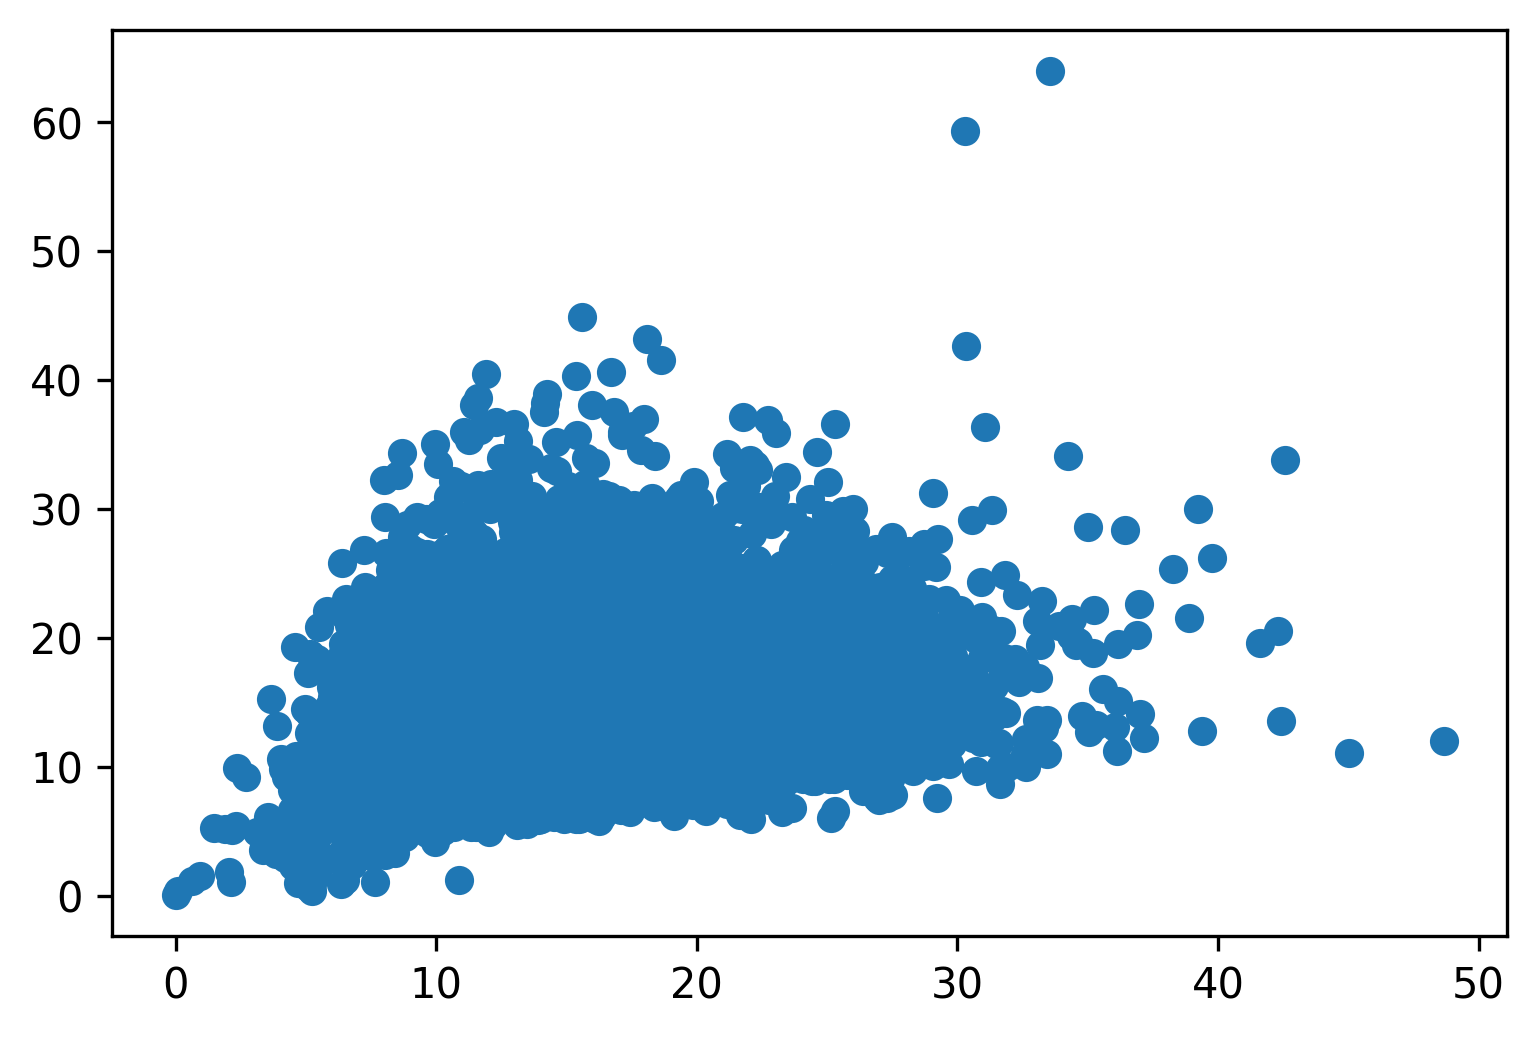

In [52]:
plt.scatter((contours_df2['xmax']-contours_df2['xmin']).values,(contours_df2['ymax']-contours_df2['ymin']).values)

In [53]:
nuclei_annotations=cv2.fillPoly(np.zeros(arr.shape[:2]), pts=contours_df2['contours'].map(lambda x:x.astype(int)).tolist(), color=1)

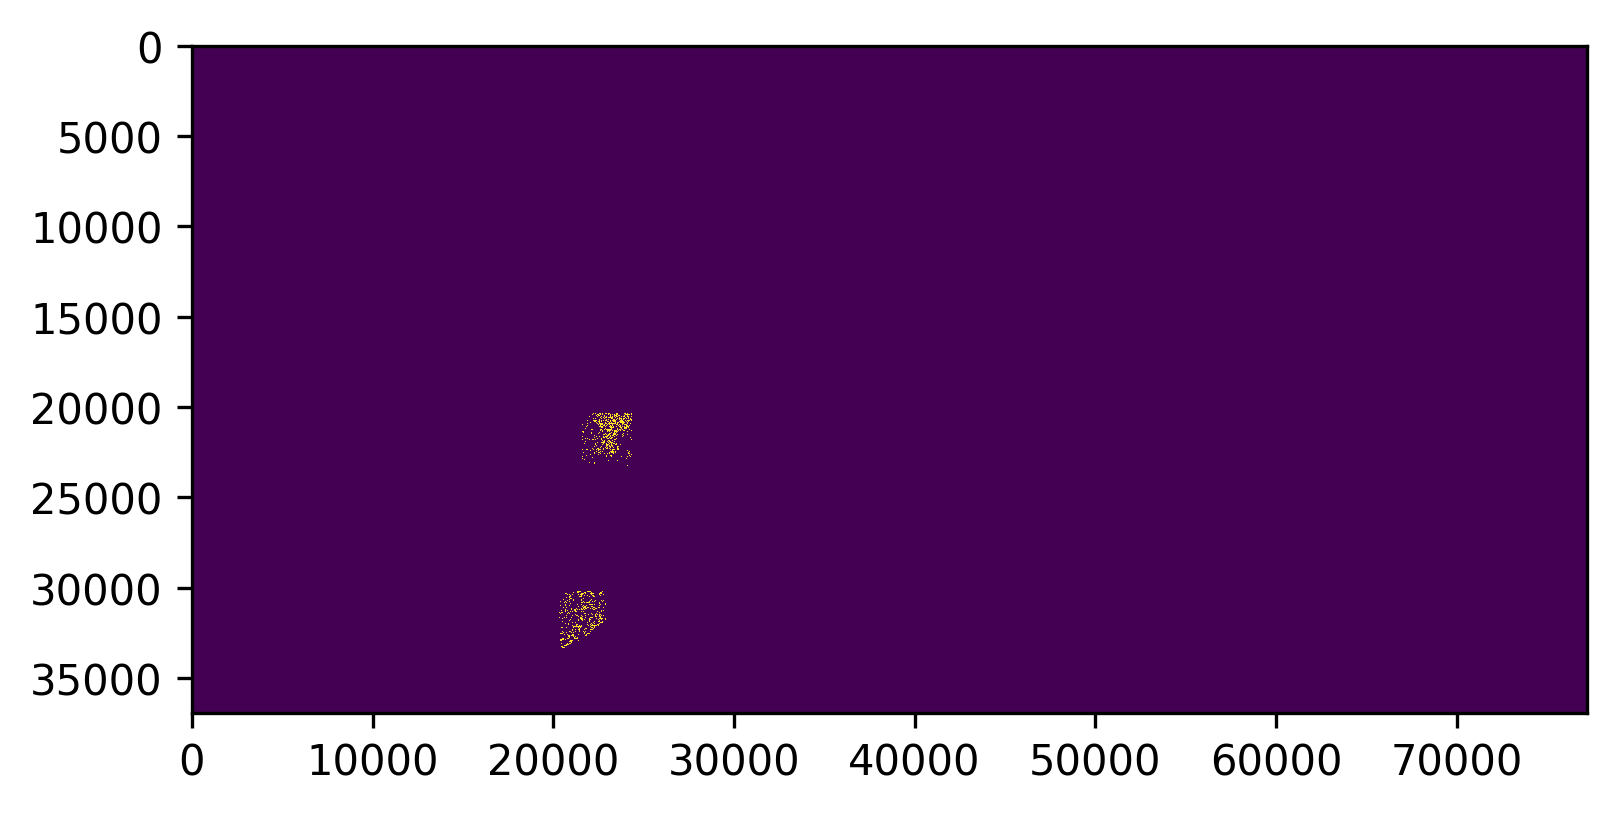

In [54]:
plt.imshow(nuclei_annotations)

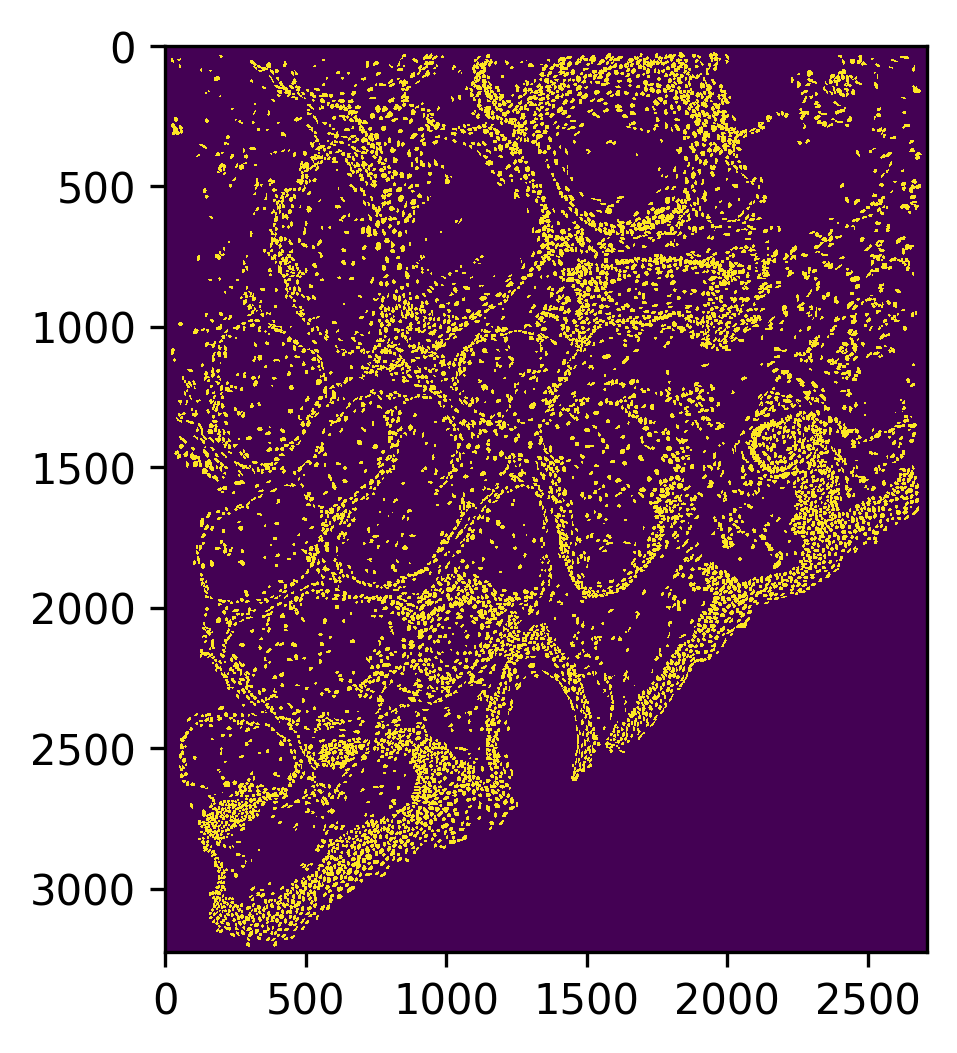

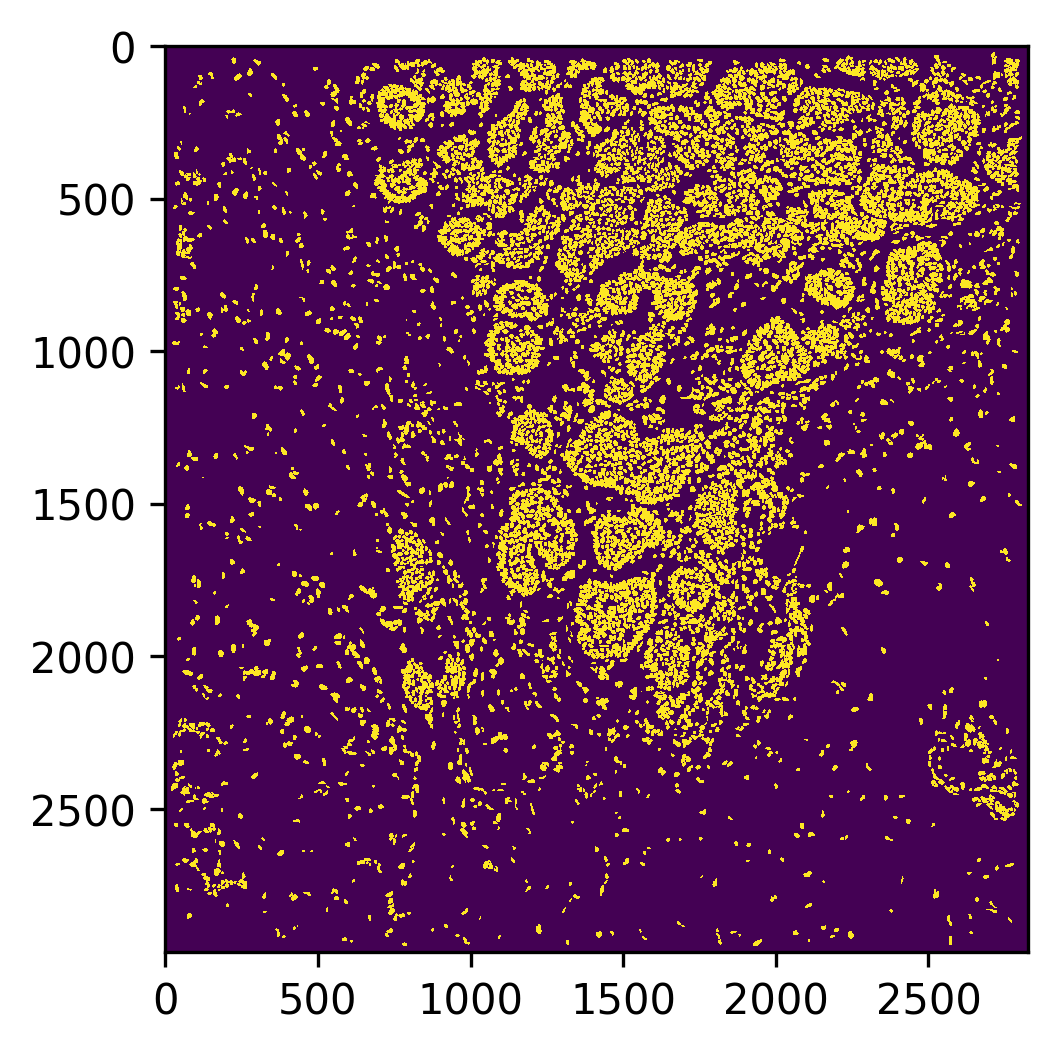

In [55]:
import copy
matplotlib.rcParams['figure.dpi']=300
cell_imgs=[]
images=[]
cluster_box=dict()
image_set=[]
for i,(name,dff) in enumerate(contours_df2.groupby("cluster")):
#     if i==2:
    xmin,xmax,ymin,ymax=dff['xmin'].min(),dff['xmax'].max(),dff['ymin'].min(),dff['ymax'].max()
    xmin,xmax,ymin,ymax=int(xmin)-20,int(xmax)+20,int(ymin)-20,int(ymax)+20
    cluster_box[name]=[xmin,xmax,ymin,ymax]
    dff.loc[:,'xmin']=dff['xmin']-xmin
    dff.loc[:,'ymin']=dff['ymin']-ymin
    dff.loc[:,'xmax']=dff['xmax']-xmin
    dff.loc[:,'ymax']=dff['ymax']-ymin
    images.append(dict(dot_annot=dff,
                       region_box=cluster_box[name]))
    plt.figure()
    plt.imshow(nuclei_annotations[ymin:ymax,xmin:xmax])#arr[ymin:ymax,xmin:xmax,:])
    image_set.append((arr[ymin:ymax,xmin:xmax,:],nuclei_annotations[ymin:ymax,xmin:xmax]))
#     plt.scatter(dff['x'],dff['y'],s=1)
    
# cv2.fillPoly(np.zeros(img.shape[:2]), pts=contour_df['contours_spline'].map(lambda x:x.astype(int)).tolist(), color=1)

# for i in range(contours_df2.shape[0]):
# #     if i==500:
#     xmin,xmax,ymin,ymax=contours_df2.iloc[i][['xmin','xmax','ymin','ymax']]
#     xmin=int(xmin)
#     ymin=int(ymin)
#     xmax=int(round(xmax))
#     ymax=int(round(ymax))
#     contour=contours_df2.iloc[i]['contours']-np.array([xmin,ymin])
#     img=copy.deepcopy(arr[ymin:ymax,xmin:xmax,:])
#     mask=poly2mask(contour[:,1],contour[:,0],img.shape[:2])
#     img[~mask]=255
#     cell_imgs.append(img)

In [56]:
from sklearn.feature_extraction.image import PatchExtractor
patch_size=100
ds=50
patches=[]
for img,image in enumerate(image_set):
    
    for x in np.arange(0,image[0].shape[0]-ds,ds).astype(int):
        for y in np.arange(0,image[0].shape[1]-ds,ds).astype(int):
            patches.append((img,image[0][x:x+patch_size,y:y+patch_size].astype(float)/255.,image[1][x:x+patch_size,y:y+patch_size].astype(int)))
        
patches=pd.DataFrame(patches)
patches=patches.loc[(patches[2].map(np.mean)>0.01)]


In [57]:
patches.shape

(5576, 3)

In [58]:
patches.to_pickle("data/131_B1e.patches.pkl")

In [61]:
import glob
# for now train and val set may have overlapping images, which is okay for now, also upsize at same ratio and then use nearest neighbors to downsize after segmentation
patches=pd.concat([pd.read_pickle(f) for f in glob.glob("data/*patches.pkl")])



In [81]:
!pwd

/dartfs/rc/lab/V/VaickusL_slow/users/jlevy/arctic_ai/prototype/nuclei_pipeline


In [69]:
patches=patches[patches[2].map(lambda x: np.product(x.shape)==10000)]

In [85]:
X,Y=np.transpose(np.stack(patches[1].tolist()),(0,3,1,2)),np.stack(patches[2].tolist())

In [86]:
X.shape

(6201, 3, 100, 100)

In [87]:
from torch.utils.data import TensorDataset
import torch
from sklearn.model_selection import train_test_split
idx=np.arange(len(X))
np.random.seed(42)
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,random_state=42,train_size=0.8)
X_train,X_val=torch.tensor(X_train).float(),torch.tensor(X_val).float()
Y_train,Y_val=torch.tensor(Y_train).long(),torch.tensor(Y_val).long()
train_dataset=TensorDataset(X_train,Y_train)
val_dataset=TensorDataset(X_val,Y_val)

In [89]:
! nvidia-smi

Fri Oct 23 10:51:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   54C    P0   221W / 250W |  26861MiB / 32510MiB |     82%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [88]:
torch.save(train_dataset,"inputs/train_data.pth")
torch.save(val_dataset,"inputs/val_data.pth")

In [82]:
! cd ../PathPretrain && git pull

remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 130 (delta 87), reused 87 (delta 44), pack-reused 0
Receiving objects: 100% (130/130), 16.55 KiB | 238.00 KiB/s, done.
Resolving deltas: 100% (87/87), completed with 3 local objects.
From https://github.com/jlevy44/PathPretrain
   a4c78fe..4c9603c  master     -> origin/master
Updating a4c78fe..4c9603c
Fast-forward
 datasets.py    |  62 ++++++++++++++++++++++
 models.py      |  73 ++++++++++++++++----------
 train_model.py | 159 ++++++++++++++++++++++++++++++++++++---------------------
 3 files changed, 209 insertions(+), 85 deletions(-)
 create mode 100644 datasets.py
